In [1]:
#!pip install gymnasium[atari]
#!pip install gymnasium[accept-rom-license]
#!pip install "gym[accept-rom-license, atari]"

# model = tf.keras.models.load_model(model_path)

In [2]:
import multiprocessing
from stable_baselines3.common.vec_env.vec_frame_stack import VecFrameStack
from stable_baselines3.common.env_util import make_atari_env

import time
import numpy as np
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from PIL import Image

2024-01-18 15:00:16.155045: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-18 15:00:16.155115: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-18 15:00:16.236802: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-18 15:00:16.408226: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-18 15:00:18.620496: W tensorflow/compiler/tf2

In [5]:
num_cpu = multiprocessing.cpu_count()
print("Number of CPUs:", num_cpu)
num_cpu = 1

env = make_atari_env("ALE/MsPacman-v5", n_envs=num_cpu)
env = VecFrameStack(env, n_stack=4)

# Get the number of lives for the first environment
env_info = env.get_attr('env_info')[0]

obs = env.reset()

Number of CPUs: 8


/home/mister/miniconda3/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.env_info to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.env_info` for environment variables or `env.get_wrapper_attr('env_info')` that will search the reminding wrappers.
  logger.warn(


AttributeError: 'AtariEnv' object has no attribute 'env_info'

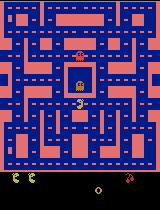

In [13]:
# Create a virtual display
display = Display(visible=0, size=(1200, 1200))
display.start()

data = {i: [[]] for i in range(num_cpu)}
tmp_data = {i: 1 for i in range(num_cpu)}

while True:
    actions = [env.action_space.sample() for _ in range(num_cpu)]
    obs, rewards, dones, info = env.step(actions)
    
    for i in range(num_cpu):
        if tmp_data[i]-1 >= len(data[i]):
            data[i].append([])
        data[i][tmp_data[i]-1].append(rewards[i])
        if dones[i]:
            tmp_data[i] += 1

    # Render the environment and display the frame
    screen = env.render()
    # Convert the RGB array to an image
    screen = Image.fromarray(screen)

    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(screen)
    
    time.sleep(1/2)  # Delay for 1/30 seconds to achieve ~30 fps

    if all([tmp_data[i] > 3 for i in range(num_cpu)]):
        break

ipythondisplay.clear_output(wait=True)
env.close()

In [3]:
print("Data", data)

Data {0: [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]]}


In [5]:
import copy

copy_data = copy.deepcopy(data)

for i in range(num_cpu):
    for j in range(len(copy_data[i])):

        copy_data[i][j] = [np.sum(copy_data[i][j]), len(copy_data[i][j])]


In [12]:
for i in range(num_cpu):
    print("Total episodes for CPU", i, ":", len(copy_data[i][0]))
    print("Total reward for CPU", i, ":", sum([copy_data[i][j][0] for j in range(len(copy_data[i]))]), "with average reward", sum([copy_data[i][j][0] for j in range(len(copy_data[i]))])/len(copy_data[i]))
    print("Total steps for CPU", i, ":", sum([copy_data[i][j][1] for j in range(len(copy_data[i]))]), "with average steps", sum([copy_data[i][j][1] for j in range(len(copy_data[i]))])/len(copy_data[i]))
    print("Weighted average reward for CPU", i, ":", sum([copy_data[i][j][0]*copy_data[i][j][1] for j in range(len(copy_data[i]))])/sum([copy_data[i][j][1] for j in range(len(copy_data[i]))]))
    print()

print("Total episodes:", sum([len(copy_data[i]) for i in range(num_cpu)]))

Total episodes for CPU 0 : 2
Total reward for CPU 0 : 61.0 with average reward 20.333333333333332
Total steps for CPU 0 : 184 with average steps 61.333333333333336
Weighted average reward for CPU 0 : 32.84782608695652

Total episodes: 3
